In [1]:
import traceback
import numpy as np
import pandas as pd

from keras.models import Model
from sklearn.metrics.pairwise import paired_cosine_distances

from Dataset import Dataset
from Discova import Discova
from Autoencoder import Autoencoder
from Prediction import Prediction
from LatentSpace import LatentSpace

Using TensorFlow backend.
/Users/nicholashirons/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style = "white", font_scale = 1.5)

## Get latent vectors

In [3]:
data = Dataset()
data.load_house_dataframe(1)
data.add_windows(1, '00 mains')

Removing timesteps above threshold......
Dropping arrays smaller than window.....
Creating windowed data..................


In [4]:
latent = LatentSpace()

In [5]:
vae_network = latent.getNetworkWithWeights('vae', 'fridge', 1)

Loading weights for House 1.............
Weights loaded. Compiling model.........


In [6]:
vae_latent_model = Model(
    inputs = vae_network.model.input,
    outputs = vae_network.model.layers[13].output
)

In [7]:
mainsWindows = latent.getMainsWindows(data, 1, outOfHouse = False)

In [8]:
vae_latent_vecs = vae_latent_model.predict(mainsWindows)

In [9]:
ae_network = latent.getNetworkWithWeights('ae', 'fridge', 1)

Loading weights for House 1.............
Weights loaded. Compiling model.........


In [10]:
ae_latent_model = Model(
    inputs = ae_network.model.input,
    outputs = ae_network.model.layers[13].output
)

In [11]:
ae_latent_vecs = ae_latent_model.predict(mainsWindows)

## Plot lines with t-SNE

In [12]:
from sklearn.manifold import TSNE

In [13]:
tsne = TSNE(n_components = 2)

In [14]:
vae_latent_tsne = tsne.fit_transform(vae_latent_vecs[:1000])

In [15]:
ae_latent_tsne = tsne.fit_transform(ae_latent_vecs[:1000])

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.collections as mcoll
import matplotlib.path as mpath

def colorline(
    x, y, z=None, cmap=plt.get_cmap('copper'), norm=plt.Normalize(0.0, 1.0),
        linewidth=3, alpha=1.0):
    """
    http://nbviewer.ipython.org/github/dpsanders/matplotlib-examples/blob/master/colorline.ipynb
    http://matplotlib.org/examples/pylab_examples/multicolored_line.html
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    """

    # Default colors equally spaced on [0,1]:
    if z is None:
        z = np.linspace(0.0, 1.0, len(x))

    # Special case if a single number:
    if not hasattr(z, "__iter__"):  # to check for numerical input -- this is a hack
        z = np.array([z])

    z = np.asarray(z)

    segments = make_segments(x, y)
    lc = mcoll.LineCollection(segments, array=z, cmap=cmap, norm=norm,
                              linewidth=linewidth, alpha=alpha)

    ax = plt.gca()
    ax.add_collection(lc)

    return lc


def make_segments(x, y):
    """
    Create list of line segments from x and y coordinates, in the correct format
    for LineCollection: an array of the form numlines x (points per line) x 2 (x
    and y) array
    """

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    return segments

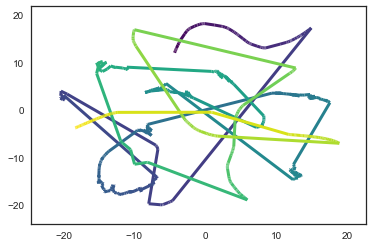

In [18]:
x = vae_latent_tsne[:,0]
y = vae_latent_tsne[:,1]

fig, axes = plt.subplots()

colorline(x, y, cmap=plt.get_cmap('viridis'))

plt.xlim(x.min()*1.2, x.max()*1.2)
plt.ylim(y.min()*1.2, y.max()*1.2)
plt.show()

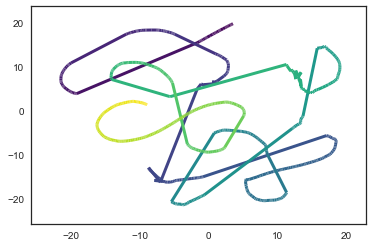

In [19]:
x = ae_latent_tsne[:,0]
y = ae_latent_tsne[:,1]

fig, axes = plt.subplots()

colorline(x, y, cmap=plt.get_cmap('viridis'))

plt.xlim(x.min()*1.2, x.max()*1.2)
plt.ylim(y.min()*1.2, y.max()*1.2)
plt.show()

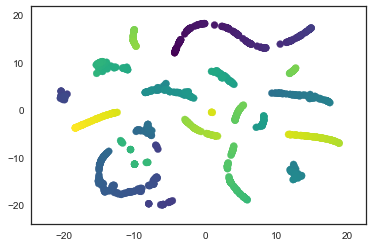

In [20]:
x = vae_latent_tsne[:,0]
y = vae_latent_tsne[:,1]

fig, axes = plt.subplots()

plt.scatter(x, y, c = np.linspace(0,1,len(x)), cmap=plt.get_cmap('viridis'))

plt.xlim(x.min()*1.2, x.max()*1.2)
plt.ylim(y.min()*1.2, y.max()*1.2)
plt.show()

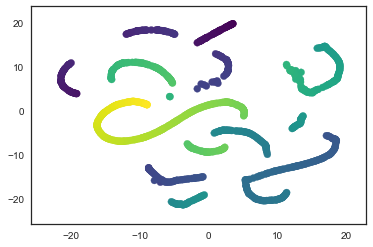

In [21]:
x = ae_latent_tsne[:,0]
y = ae_latent_tsne[:,1]

fig, axes = plt.subplots()

plt.scatter(x, y, c = np.linspace(0,1,len(x)), cmap=plt.get_cmap('viridis'))

plt.xlim(x.min()*1.2, x.max()*1.2)
plt.ylim(y.min()*1.2, y.max()*1.2)
plt.show()

## Plot PCA

In [22]:
from sklearn.decomposition import PCA

In [34]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [23]:
pca = PCA()

In [24]:
vae_latent_pca = pca.fit_transform(vae_latent_vecs)
ae_latent_pca = pca.fit_transform(ae_latent_vecs)

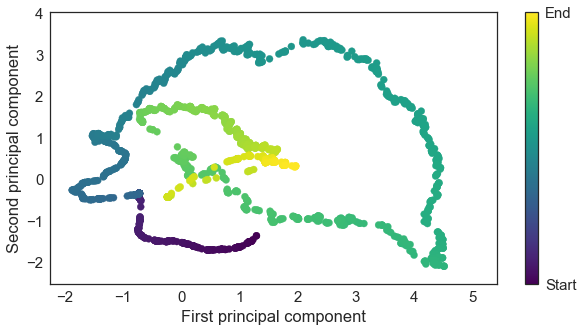

In [67]:
x = vae_latent_pca[:,0][:2000]
y = vae_latent_pca[:,1][:2000]

fig, ax = plt.subplots(figsize = (10,5))

plt.scatter(x, y, c = np.linspace(0,1,len(x)), cmap=plt.get_cmap('viridis'))

cbar = plt.colorbar(ticks = [0,1])
cbar.ax.set_yticklabels(['Start','End'])

ax.set_xlabel('First principal component')
ax.set_ylabel('Second principal component')

plt.xlim(x.min()*1.2, x.max()*1.2)
plt.ylim(y.min()*1.2, y.max()*1.2)
plt.show()

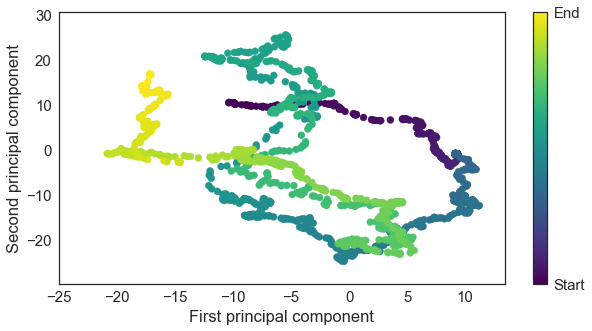

In [68]:
x = ae_latent_pca[:,0][:2000]
y = ae_latent_pca[:,1][:2000]

fig, ax = plt.subplots(figsize = (10,5))

plt.scatter(x, y, c = np.linspace(0,1,len(x)), cmap=plt.get_cmap('viridis'))

cbar = plt.colorbar(ticks = [0,1])
cbar.ax.set_yticklabels(['Start','End'])

ax.set_xlabel('First principal component')
ax.set_ylabel('Second principal component')

plt.xlim(x.min()*1.2, x.max()*1.2)
plt.ylim(y.min()*1.2, y.max()*1.2)
plt.show()